In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import csv
from matplotlib.backends.backend_pdf import PdfPages
from scipy.cluster.vq import vq, kmeans, whiten
from collections import Counter
#from stackedBarGraph import StackedBarGrapher
import colorsys
from scipy.stats import beta
import matplotlib.gridspec as gridspec
import random
import sys
import matplotlib.colors as colors
import matplotlib.cm as cmx

%matplotlib inline

In [2]:
Delta_t = 0.25
Use = np.genfromtxt('InputData/PecanUseApr2015.csv', delimiter=',')
Gen = np.genfromtxt('InputData/PecanGenApr2015.csv', delimiter=',')
TotUse = np.sum(Use, axis=1)*Delta_t

In [3]:
for i in np.arange(0,101,20):
    print str(i), 'percentile of use:', np.nanpercentile(TotUse, i)

0 percentile of use: 0.0
20 percentile of use: 321.655552
40 percentile of use: 481.8316595
60 percentile of use: 667.7741345
80 percentile of use: 939.943031
100 percentile of use: 5906.7154525


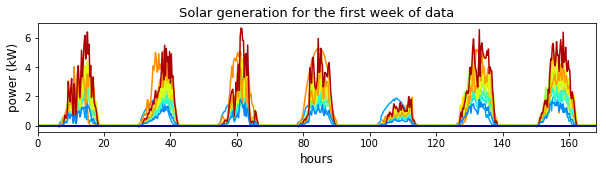

In [4]:
# inspect Gen to see which day wanna take
cm3 = plt.cm.get_cmap('jet')
cNorm3 = colors.Normalize(vmin=0, vmax=7)
scalarMap3 = cmx.ScalarMappable(norm=cNorm3, cmap=cm3)
scalarMap3._A = []
# redder is more users
fs = 12
fig = plt.figure()
fig.set_size_inches(10,2)
ax1 = fig.add_subplot(111)
for i in np.arange(0,550,10):
    cl = scalarMap3.to_rgba(max(Gen[i,0:672]))
    ax1.plot(np.linspace(0.25,168,672), Gen[i,0:672], color=colors.rgb2hex(cl)) 
ax1.set_xlabel('hours', fontsize=fs)
ax1.set_ylabel('power (kW)', fontsize=fs)
ax1.set_title('Solar generation for the first week of data', fontsize=fs+1)
ax1.set_xlim([0,168]);

0 percentile GEN 0.0
20 percentile GEN 323.96256800000003
40 percentile GEN 483.9840765
60 percentile GEN 587.2034035
80 percentile GEN 641.172291
100 percentile GEN 1388.3099725000002


Text(0,0.5,'generation (kWh)')

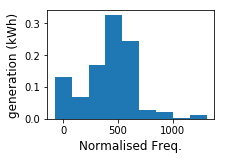

In [5]:
TotGen = np.sum(Gen, axis=1)*Delta_t
for i in np.arange(0,101,20):
    print str(i), 'percentile GEN', np.nanpercentile(TotGen, i)
#plus a histogram of the av daily use
binsGen = np.linspace(np.nanmin(TotGen),np.nanmax(TotGen),10)
hist, bin_edges = np.histogram(TotGen[~np.isnan(TotGen)], binsGen, density=False)
fig = plt.figure()
fig.set_size_inches(3,2)
ax1 = fig.add_subplot(111)
ax1.bar(bin_edges[0:-1], hist/float(sum(hist)), width=(bin_edges[1:]-bin_edges[0:-1]))
ax1.set_xlabel('Normalised Freq.', fontsize = fs)
ax1.set_ylabel('generation (kWh)', fontsize=fs)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


Text(0,0.5,'frequency')

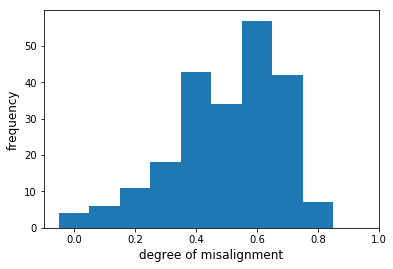

In [6]:
a1 = np.where((TotGen>100))[0]
# calculate the misalignment in the actual data
mis = np.zeros((len(a1)))
for i, pLoad in enumerate(Use[a1]):
    load = pLoad - Gen[a1[i],:]
    mis[i] = -np.sum(load[load<0])/np.sum(Gen[a1[i],:])
misBins = np.arange(0,1.1,0.1)
misHist, mH_edges = np.histogram(mis, misBins, density=False)
fs = 12
misWidths = mH_edges[1:]-mH_edges[:-1]
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.bar(misBins[:-1], misHist, width=misWidths)
ax1.set_xlabel('degree of misalignment',fontsize=fs)
ax1.set_ylabel('frequency',fontsize=fs)

(Text(0.5,0,'total use (kWh)'), Text(0,0.5,'Freq.'))

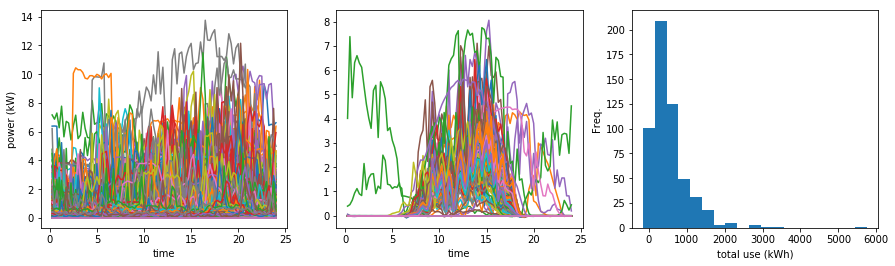

In [7]:
N = np.shape(Use)[0]
# inspect use and gen
fig = plt.figure()
fig.set_size_inches(15,4)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
for idx in range(N):
    ax1.plot(np.linspace(0.25,24,96), Use[idx,0:96])
    ax2.plot(np.linspace(0.25,24,96), Gen[idx,0:96])
    ax1.set_ylabel('load (kW)'), ax1.set_ylabel('power (kW)'), ax1.set_xlabel('time'), ax2.set_xlabel('time')
monthlyToUse = [None]
#plus a histogram of the av daily use
binsUse = np.linspace(np.nanmin(TotUse),np.nanmax(TotUse),20)
hist, bin_edges = np.histogram(TotUse[~np.isnan(TotUse)], binsUse, density=False)
ax1 = fig.add_subplot(133)
ax1.bar(bin_edges[0:-1], hist, width=(bin_edges[1:]-bin_edges[0:-1]))
ax1.set_xlabel('total use (kWh)'), ax1.set_ylabel('Freq.')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


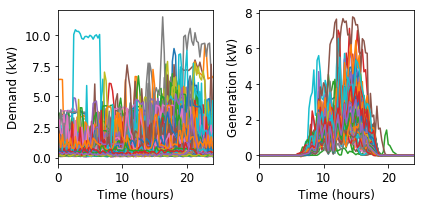

In [8]:
# print np.shape(Gen), np.shape(Use)  
# inspect the data where both use and gen are appropriate
i1 = np.where(np.isnan(TotUse)==True)[0]
i2 = np.where(TotUse>2000)[0]
i3 = np.where(TotUse<100)[0]
i4 = []
for i, u in enumerate(Use):
    if len(np.where(u<=0)[0]) > 10:
        i4.append(i)      
i5 = np.where(np.isnan(np.sum(Gen, axis=1))==True)[0]
i6 = np.where(np.max(Gen, axis=1)<=0.5)[0]
# check if any value between 0 and 6am and 9pm onwards
# 6am = 24, 9pm = 84
i7 = []
for i, g in enumerate(Gen):
    if any(g[0:24]>0.1) or any(g[84:96]>0.1):
        i7.append(i)
# now join list and delete where appropriate
i8 = np.concatenate((i1,i2,i3,i4,i5,i6,i7), axis=0)

# just used to get the misalignments for April, deleting all entries without GEN and USE
testUse = np.delete(Use, np.unique(i8), 0)
testGen = np.delete(Gen, np.unique(i8), 0)

fs = 12
# inspect use and gen
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for idx in range(len(testUse)):
    ax1.plot(np.linspace(0.25,24,96), testUse[idx,0:96])
    ax2.plot(np.linspace(0.25,24,96), testGen[idx,0:96])
ax1.set_xlim([0,24])
ax2.set_xlim([0,24])
ax1.set_xlabel('Time (hours)', fontsize=fs)
ax2.set_xlabel('Time (hours)', fontsize=fs)
ax1.set_ylabel('Demand (kW)', fontsize=fs)
ax2.set_ylabel('Generation (kW)', fontsize=fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax2.tick_params(axis='both', which='major', labelsize=fs)
fig.tight_layout()
#fig.savefig('Pec15minDGProfiles.png', dpi=300, bbox_inches = 'tight',format='png')

0.12778328643518147 2.5917100149471697
[ 0.11011362 -0.48326665  0.56785822]
[[ 2.67730626e-05 -6.31483221e-06 -1.58296312e-04]
 [-6.31483221e-06  1.06309901e-03 -9.43508655e-04]
 [-1.58296312e-04 -9.43508655e-04  3.80244210e-03]]


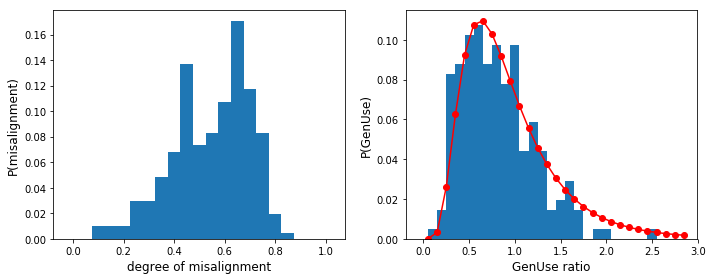

In [9]:
l1 = len(testUse)
# now plot the misalignments for these users
mis = np.zeros((l1))
for i, pLoad in enumerate(testUse):
    load = pLoad - testGen[i,:]
    mis[i] = -np.sum(load[load<0])/np.sum(testGen[i,:])
misBins = np.arange(0,1.1,0.05)
misHist, mH_edges = np.histogram(mis, misBins, density=False)
fs = 12
misWidths = mH_edges[1:]-mH_edges[:-1]
fig1 = plt.figure()
fig1.set_size_inches(10,4)
ax1 = fig1.add_subplot(121)
ax1.bar(misBins[:-1], misHist/float(sum(misHist)), width=misWidths)
ax1.set_xlabel('degree of misalignment',fontsize=fs)
ax1.set_ylabel('P(misalignment)',fontsize=fs)

#np.savetxt('IntermediateData/AustinMisalignment.dat', misHist/float(sum(misHist)), delimiter=',', fmt='%.5f')

pecRats = np.zeros((l1))
for i, pLoad in enumerate(testUse):
    pecRats[i] = np.sum(testGen[i,:])/np.sum(pLoad)

print np.min(pecRats), np.max(pecRats)
    
UGBins = np.arange(0,3,0.1)
UGHist, UG_edges = np.histogram(pecRats, UGBins, density=False)
UGWidths = UG_edges[1:]-UG_edges[:-1]
ax1 = fig1.add_subplot(122)
ax1.bar(UGBins[:-1], UGHist/float(sum(UGHist)), width=UGWidths)
ax1.set_xlabel('GenUse ratio',fontsize=fs)
ax1.set_ylabel('P(GenUse)',fontsize=fs)

from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp( -((np.log(x)-b)**2)/c )

xdata = UGBins[0:-1]+(UGBins[1]-UGBins[0])/2
y = func(xdata, 1, 1, 1.1)
ydata = UGHist/float(np.sum(UGHist))
popt, pcov = curve_fit(func, xdata, ydata)
print popt
print pcov

# now inspect the curve fit
ydata = func(UGBins[0:-1]+(UGBins[1]-UGBins[0])/2, popt[0], popt[1], popt[2])
ax1.plot(UGBins[0:-1]+(UGBins[1]-UGBins[0])/2, ydata, linewidth=1.5, color='r', marker='o')
fig1.tight_layout()

In [10]:
# calculate the misalignments when data is aggregated to hourly
print np.shape(testUse)
testUse24 = np.zeros((np.shape(testUse)[0],np.shape(testUse)[1]/4))
testGen24 = np.zeros((np.shape(testUse)[0],np.shape(testUse)[1]/4))
for i in range(int(np.shape(testUse)[1]/4.)):
    indx = i*4
    testUse24[:,i] = np.sum(testUse[:,indx:indx+4], axis=1)
    testGen24[:,i] = np.sum(testGen[:,indx:indx+4], axis=1)
# now plot the 15min and hourly misalignments
l1 = len(testUse)
# now plot the misalignments for these users
misH = np.zeros((l1))
for i, pLoad in enumerate(testUse24):
    load = pLoad - testGen24[i,:]
    misH[i] = -np.sum(load[load<0])/np.sum(testGen24[i,:])
misHistH, mH_edgesH = np.histogram(misH, misBins, density=False)
fs = 12
misWidths = mH_edges[1:]-mH_edges[:-1]

(205, 2880)


In [11]:
print 'Misalignment 15 min:', np.mean(mis), 'Misalignment hourly:', np.mean(misH)
testUse, testGen = [None], [None]

Misalignment 15 min: 0.5732132276583219 Misalignment hourly: 0.5489941012999742


In [12]:
#### now delete entries where data doesn't make sense
# Different from above as number of use and gen entries are DIFFERENT
# this includes useData where more than 10 entries are zero
# useData where monthlyTotUse is nan
# genData where nan
# genData where misaligned - so solar peak is at night
i1 = np.where(np.isnan(TotUse)==True)[0]
i2 = np.where(TotUse>2000)[0]
i3 = np.where(TotUse<100)[0]
i4 = []
# check if more than 10 zero entries
for i, u in enumerate(Use):
    if len(np.where(u<=0)[0]) > 10:
        i4.append(i)
# as below
for i, g in enumerate(Gen):
    if any(g[0:24]>0.1) or any(g[84:96]>0.1):
        i4.append(i)
# now join list and delete where appropriate
i5 = np.concatenate((i1,i2,i3,i4), axis=0)

Use = np.delete(Use, np.unique(i5), 0)
TotUse = np.delete(TotUse, np.unique(i5), 0)
print 'Usage shape ', np.shape(Use)

i1 = np.where(np.isnan(np.sum(Gen, axis=1))==True)[0]
i2 = np.where(np.max(Gen, axis=1)<=0.5)[0]
# check if any value between 0 and 6am and 9pm onwards
# 6am = 24, 9pm = 84
i3 = []
for i, g in enumerate(Gen):
    if any(g[0:24]>0.1) or any(g[84:96]>0.1):
        i3.append(i)       
i5 = np.concatenate((i1,i2,i3), axis=0)

Gen = np.delete(Gen, np.unique(i5), 0)
print 'Generation shape', np.shape(Gen)

Usage shape  (482, 2880)
Generation shape (216, 2880)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


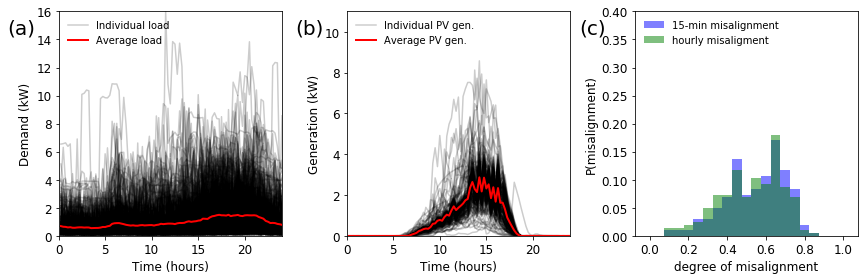

In [13]:
fig = plt.figure()
fig.set_size_inches(12, 4)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)

# select a day to plot
nn = np.random.randint(0,29)
nn = 1
for idx in range(len(Use)):
    l1, = ax1.plot(np.linspace(0.25,24,96), Use[idx,96*nn:96*(nn+1)], color='k', alpha=0.2)
l2, = ax1.plot(np.linspace(0.25,24,96), np.average(Use[:,96*nn:96*(nn+1)], axis=0), linewidth=2, color='r')
for idx in range(len(Gen)):
    ax2.plot(np.linspace(0.25,24,96), Gen[idx,96*nn:96*(nn+1)], color='k', alpha=0.2)
ax2.plot(np.linspace(0.25,24,96), np.average(Gen[:,96*nn:96*(nn+1)], axis=0), linewidth=2, color='r')
    
ax1.set_xlim([0,24])
ax2.set_xlim([0,24])
ax1.set_xlabel('Time (hours)', fontsize=fs)
ax2.set_xlabel('Time (hours)', fontsize=fs)
ax1.set_ylabel('Demand (kW)', fontsize=fs)
ax2.set_ylabel('Generation (kW)', fontsize=fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax2.tick_params(axis='both', which='major', labelsize=fs)
ax1.legend([l1,l2], ['Individual load','Average load'], loc=2, frameon=False)
ax2.legend([l1,l2], ['Individual PV gen.','Average PV gen.'], loc=2, frameon=False)
ax1.set_ylim([0,16])
ax2.set_ylim([0, 11])
ax1.text(-0.23,0.9,'(a)',transform = ax1.transAxes,fontsize=20)
ax2.text(-0.23,0.9,'(b)',transform = ax2.transAxes,fontsize=20)

    
ax1 = fig.add_subplot(133)
ax1.bar(misBins[:-1], misHist/float(sum(misHist)), width=misWidths, color='b', alpha=0.5)
ax1.bar(misBins[:-1], misHistH/float(sum(misHistH)), width=misWidths, color='g', alpha=0.5)
ax1.set_xlabel('degree of misalignment',fontsize=fs)
ax1.set_ylabel('P(misalignment)',fontsize=fs)
r1 = plt.Rectangle((0, 0), 1, 1, fc='blue', alpha=0.5)
r2 = plt.Rectangle((0, 0), 1, 1, fc='green', alpha=0.5)
ax1.legend([r1,r2], ['15-min misalignment', 'hourly misaligment'], loc=2, frameon=False)
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.set_ylim([0, 0.4])
ax1.text(-0.25,0.9,'(c)',transform = ax1.transAxes,fontsize=20)
fig.tight_layout()
# fig.savefig('Images/Mis15min.png', dpi=300,bbox_inches = 'tight',format='png')    
    

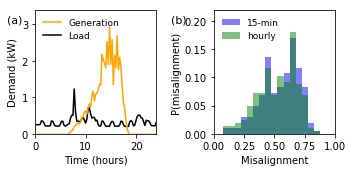

In [14]:
fig = plt.figure()
fig.set_size_inches(5, 2.5)
ax1 = fig.add_subplot(121)

fs = 10

# select a day to plot
nn = np.random.randint(0,29)
nn = 1
for idx in range(len(Use)):
    l1, = ax1.plot(np.linspace(0.25,24,96), Use[idx,96*nn:96*(nn+1)], color='k', alpha=1)
    break
#l2, = ax1.plot(np.linspace(0.25,24,96), np.average(Use[:,96*nn:96*(nn+1)], axis=0), linewidth=2, color='r')
for idx in range(len(Gen)):
    l2, = ax1.plot(np.linspace(0.25,24,96), Gen[idx,96*nn:96*(nn+1)], color='orange', alpha=1)
    break
#ax2.plot(np.linspace(0.25,24,96), np.average(Gen[:,96*nn:96*(nn+1)], axis=0), linewidth=2, color='r')
    
ax1.set_xlim([0,24])
ax1.set_xlabel('Time (hours)', fontsize=fs)
ax1.set_ylabel('Demand (kW)', fontsize=fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.legend([l2,l1], ['Generation','Load'], loc=2, frameon=False, fontsize=fs-1)
ax1.set_ylim([0,3.4])
ax1.text(-0.23,0.9,'(a)',transform = ax1.transAxes,fontsize=11)
ax1.set_yticks(np.arange(0,3.1,1))

ax1 = fig.add_subplot(122)
ax1.bar(misBins[:-1], misHist/float(sum(misHist)), width=misWidths, color='b', alpha=0.5)
ax1.bar(misBins[:-1], misHistH/float(sum(misHistH)), width=misWidths, color='g', alpha=0.5)
ax1.set_xlabel('Misalignment',fontsize=fs)
ax1.set_ylabel('P(misalignment)',fontsize=fs)
r1 = plt.Rectangle((0, 0), 1, 1, fc='blue', alpha=0.5)
r2 = plt.Rectangle((0, 0), 1, 1, fc='green', alpha=0.5)
ax1.legend([r1,r2], ['15-min', 'hourly'], loc=2, frameon=False, fontsize=fs-1)
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.set_ylim([0, 0.22])
ax1.set_xlim([0, 1])
ax1.set_yticks(np.arange(0,0.21,0.05))
ax1.text(-0.35,0.9,'(b)',transform = ax1.transAxes,fontsize=11)
fig.tight_layout()
#fig.savefig('Images/CESnew1.png', dpi=300,bbox_inches = 'tight',format='png')  

In [15]:
mis[0]
print np.mean(misH)

0.5489941012999742


In [16]:
data_single = np.genfromtxt('IntermediateData/SingleHomesConsumption.csv', delimiter=',', skip_header=1, dtype=None)

# get the monthly average consumption
data_mat = [[x for x in data_single[y]] for y in np.arange(np.shape(data_single)[0])]
#parcelIdx = [x[0] for x in data_mat]
parcelCentroids = [x[2:4] for x in data_mat]
accountIdx = [x[4] for x in data_mat]
monthAvUse = [x[0] for x in data_mat]
mgNumber = [x[1] for x in data_mat]

print len(set(accountIdx))

4574


In [17]:
def CambridgeBills():
    print 'Importing monthly consuption data from Cambridge residential accounts...'
    # get the consumption over 12 months for single users
    data_single = np.genfromtxt('IntermediateData/SingleHomesConsumption.csv', delimiter=',', skip_header=1, dtype=None)
    
    # get the monthly average consumption
    data_mat = [[x for x in data_single[y]] for y in np.arange(np.shape(data_single)[0])]
    #parcelIdx = [x[0] for x in data_mat]
    parcelCentroids = [x[2:4] for x in data_mat]
    accountIdx = [x[4] for x in data_mat]
    monthAvUse = [x[0] for x in data_mat]
    mgNumber = [x[1] for x in data_mat]
    
    print 'Found ', np.shape(data_mat)[0], ' cambridge users'
    return np.asarray(monthAvUse), np.asarray(mgNumber), np.asarray(parcelCentroids), np.asarray(accountIdx)

In [18]:
def PecanCambrMatch(pecanDem, cambrUse, pecanMonthly):
    print 'Matching Cambridge monthly consumption with Pecan St. profiles...'
    cambrDem = np.zeros((len(cambrUse), np.shape(pecanDem)[1]))
    Usebin = np.asarray([200,500,800,1100,1400,2001])
    np.argsort(pecanMonthly)
    hist, bin_edges = np.histogram(pecanMonthly, bins=Usebin, density=False)
    binNo = np.digitize(cambrUse, bin_edges)
    
    print binNo
    for n in np.arange(len(cambrUse)):
        candidates = np.where((pecanMonthly>bin_edges[binNo[n]-1]) & (pecanMonthly<bin_edges[binNo[n]]))
        if len(candidates[0] != 0):
            r = np.random.randint(0, len(candidates[0]))
            # add an extra (cUse-pUse)/(24*30) kW to each reading
            cambrDem[n] = pecanDem[candidates[0][r]] + (cambrUse[n]-pecanMonthly[candidates[0][r]])/(24*30)#because in kW NOT kWh
        #-----introduce noise------------------------------------------------------
        for h in np.arange(96*30):
            noise = np.average(np.random.random(100)*2 - 1)
            cambrDem[n, h] = (1 + 0.2*noise) * cambrDem[n, h]
            if cambrDem[n,h] < 0:
                cambrDem[n,h] = -cambrDem[n,h]
                
    return cambrDem

Importing monthly consuption data from Cambridge residential accounts...
Found  4574  cambridge users
0 percentile Cambridge Use: 201.0 kWh
20 percentile Cambridge Use: 327.0 kWh
40 percentile Cambridge Use: 488.0 kWh
60 percentile Cambridge Use: 708.0 kWh
80 percentile Cambridge Use: 1045.0 kWh
100 percentile Cambridge Use: 2000.0 kWh
Matching Cambridge monthly consumption with Pecan St. profiles...
[3 4 2 ... 3 3 2]


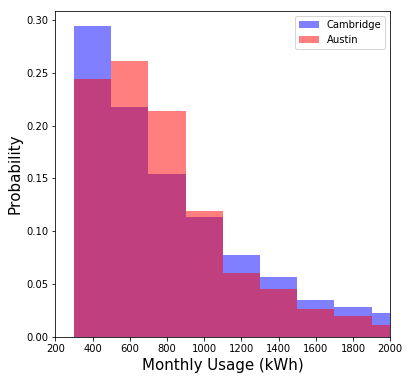

In [19]:
# convert TotUse into monthlyUse
monthlyTotUse = TotUse+0.

CambrUse, mgNumber, parcelCentroids, accountIdx = CambridgeBills()
for i in np.arange(0,101,20):
    print str(i), 'percentile Cambridge Use:', np.percentile(CambrUse,i), 'kWh'
    
# plot the Cambridge and Pecan street monthly usage distribution
hist, bin_edges = np.histogram(CambrUse, bins=np.arange(200, 2200, 200), density=False)
hist_norm = np.asarray(hist, dtype=float)/ np.sum(hist)
fig = plt.figure()
ax1 = fig.add_subplot(111)
fig.set_size_inches(6.0, 6.0)
widths = bin_edges[:-1] - bin_edges[1:]
ax1.bar(bin_edges[1:], hist_norm, width=widths, alpha=0.5, color='b')
ax1.set_xlabel('Monthly Usage (kWh)', fontsize=15)
ax1.set_ylabel('Probability', fontsize=15)
ax1.set_xlim([200, 2000])
hist, bin_edges = np.histogram(monthlyTotUse, bins=np.arange(200, 2200, 200), density=False)
hist_norm = np.asarray(hist, dtype=float)/ np.sum(hist)
ax1.bar(bin_edges[1:], hist_norm, width=widths, alpha=0.5, color='r')

r1 = plt.Rectangle((0, 0), 1, 1, fc="blue", alpha=0.5)
r2 = plt.Rectangle((0, 0), 1, 1, fc="red", alpha=0.5)
ax1.legend([r1, r2], ['Cambridge', 'Austin'], loc=1)
ax1.tick_params(axis='both', which='major', labelsize=fs)

#fig.savefig('Images/MonthlyUsages.png', dpi=300, bbox_inches='tight',format='png')

cambridgeDemand = PecanCambrMatch(Use, CambrUse, monthlyTotUse)

In [20]:
print mgNumber

[  0.   0.   0. ... 199. 199. 199.]


In [21]:
with open('IntermediateData/Workspace96.csv', 'wb') as OutFile:
    writer = csv.writer(OutFile)
    for i in np.arange(len(accountIdx)):
        RowData = []
        for j in cambridgeDemand[i,:]:
            RowData.append( "%.5f" % j )
        RowData.append(mgNumber[i])
        RowData.append(accountIdx[i])
        RowData.append(parcelCentroids[i,0])
        RowData.append(parcelCentroids[i,1])
        writer.writerow(RowData)

filename = 'IntermediateData/Workspace96.csv'
WSpace = []
with open(filename) as InFile:
    reader = csv.reader(InFile, delimiter=',')
    for row in reader:
        WSpace.append(row)
        
cambridgeDemand = np.zeros((len(WSpace),96*30))
for i in np.arange(len(WSpace)):
    cambridgeDemand[i,:] = WSpace[i][0:96*30]

In [22]:
# here we need to create 3 30 day slots of generation data
gen1 = np.genfromtxt('InputData/PecanGenFebMar2.csv', delimiter=',')
gen2 = np.genfromtxt('InputData/PecanGenMay1_30.csv', delimiter=',')
gen3 = np.genfromtxt('InputData/PecanGenDec1_30.csv', delimiter=',')
[a,b] = np.shape(gen1)
Gen0 = np.zeros((a,b*3))
Gen0[:,0:2880] = gen1
Gen0[:,2880:2880*2] = gen2
Gen0[:,2880*2:2880*3] = gen3

# at the end the aim is to save 3 different files for the generation --> 3 different months for each panel
# Remove entries which dont make sense (nans, peaks at night, max less than 0.5kW, too many zeros)
i1 = np.where(np.isnan(np.sum(Gen0, axis=1))==True)[0]
i2 = np.where(np.max(Gen0, axis=1)<=0.5)[0]
# check if any value between 0 and 6am and 9pm onwards
# 6am = 24, 9pm = 84
i3 = []
for i, g in enumerate(Gen0):
    if any(g[0:20]>0.1) or any(g[90:96]>0.1):
        i3.append(i)
for i, g in enumerate(Gen0):
    if any(g[5*96+0:5*96+20]>0.1) or any(g[5*96+86:5*96+96]>0.1):
        i3.append(i)
for i, g in enumerate(Gen0):
    if any(g[34*96+0:34*96+20]>0.1) or any(g[34*96+86:34*96+96]>0.1):
        i3.append(i)
for i, g in enumerate(Gen0):
    if any(g[50*96+0:50*96+20]>0.1) or any(g[50*96+86:50*96+96]>0.1):
        i3.append(i)
for i, g in enumerate(Gen0):
    if any(g[70*96+0:70*96+20]>0.1) or any(g[70*96+86:70*96+96]>0.1):
        i3.append(i)
# check where there are too many days that sum to zero
daySum = np.zeros((a,90))
for j,g in enumerate(Gen0):
    for i in range(90):
        daySum[j, i] = np.sum(g[i*96:(i+1)*96])

zeroThreshInd = []
for i, u in enumerate(daySum):
    if len(np.where(u<=0)[0]) > 20:
        zeroThreshInd.append(i)  
print 'there are ', len(zeroThreshInd), 'instances where zero threshold exceeded'

i5 = np.concatenate((i1,i2,i3,zeroThreshInd), axis=0)

Gen0 = np.delete(Gen0, np.unique(i5), 0)
print 'Found are ', np.shape(Gen0)[0], ' suitable generation profiles for all the months'

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater


there are  217 instances where zero threshold exceeded
Found are  165  suitable generation profiles for all the months


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less_equal


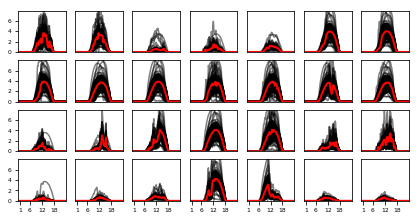

In [23]:
# plotting the first four weeks (out of 30 days) for the average month (Feb in Austin, yr average for Cambridge)
fig, axs = plt.subplots(4,7, figsize=(7, 3.5), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(28):
    for usr in range(len(Gen0)):
        index1 = 96*i
        index2 = 96*(i+1)
        axs[i].plot(np.linspace(0.25,24,96), Gen0[usr, index1:index2], color = 'black', alpha=0.5)
    axs[i].plot(np.linspace(0.25,24,96), np.average(Gen0[:,index1:index2], axis=0), color = 'red', linewidth=2, alpha=1)
    if i in [0,7,14,21]:
        axs[i].set_yticks([0,2,4,6])
    else:
        axs[i].set_yticks([])
    if i in [21,22,23,24,25,26,27]:
        axs[i].set_xticks([1,6,12,18]) 
    else:
        axs[i].set_xticks([])
    axs[i].set_xlim([0,24])
    axs[i].set_ylim([0,8])
    axs[i].tick_params(axis='both', labelsize=fs-4)

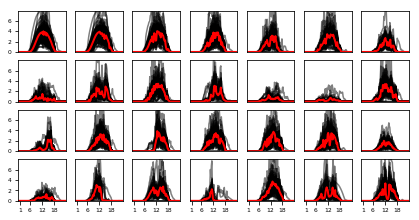

In [24]:
# plotting the first four weeks (out of 30 days) for summer month (May in Austin, June in Cambridge)
fig, axs = plt.subplots(4,7, figsize=(7, 3.5), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(30,58):
    for usr in range(len(Gen0)):
        index1 = 96*i
        index2 = 96*(i+1)
        axs[i-30].plot(np.linspace(0.25,24,96), Gen0[usr, index1:index2], color = 'black', alpha=0.5)
    axs[i-30].plot(np.linspace(0.25,24,96), np.average(Gen0[:,index1:index2], axis=0), color = 'red', linewidth=2, alpha=1)
    if i in ([30,37,44,51]):
        axs[i-30].set_yticks([0,2,4,6])
    else:
        axs[i-30].set_yticks([])
    if i in ([51,52,53,54,55,56,57]):
        axs[i-30].set_xticks([1,6,12,18]) 
    else:
        axs[i-30].set_xticks([])
    axs[i-30].set_xlim([0,24])
    axs[i-30].set_ylim([0,8])
    axs[i-30].tick_params(axis='both', labelsize=fs-4)

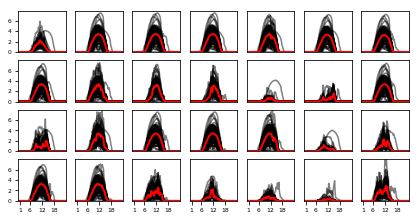

In [25]:
# plotting the first four weeks (out of 30 days) for the winter month (Dec in Austin/Feb in Cambridge)
fig, axs = plt.subplots(4,7, figsize=(7, 3.5), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(60,88):
    for usr in range(len(Gen0)):
        index1 = 96*i
        index2 = 96*(i+1)
        axs[i-60].plot(np.linspace(0.25,24,96), Gen0[usr, index1:index2], color = 'black', alpha=0.5)
    axs[i-60].plot(np.linspace(0.25,24,96), np.average(Gen0[:,index1:index2], axis=0), color = 'red', linewidth=2, alpha=1)
    if i in [x+60 for x in [0,7,14,21]]:
        axs[i-60].set_yticks([0,2,4,6])
    else:
        axs[i-60].set_yticks([])
    if i in [x+60 for x in [21,22,23,24,25,26,27]]:
        axs[i-60].set_xticks([1,6,12,18]) 
    else:
        axs[i-60].set_xticks([])
    axs[i-60].set_xlim([0,24])
    axs[i-60].set_ylim([0,8])
    axs[i-60].tick_params(axis='both', labelsize=fs-4)

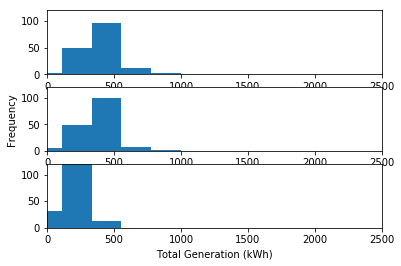

In [29]:
# now correct the solar data to match Bos yearly
relCorrection3 = np.genfromtxt('IntermediateData/relCorrection.dat')

fig = plt.figure()
axs = []
for k in range(3):
    axs.append( fig.add_subplot(3,1,k+1) )

for k in range(3):
    transformedData = np.zeros(np.shape(Gen0[:,0:2880]))
    relCorrection = relCorrection3[k,:]
    for j in range(len(Gen0)):
        for i in range(30):
            dummyGen = Gen0[j, (30*k+i)*96:(30*k+i+1)*96]
            transformedData[j, i*96:i*96+92]=dummyGen[4:96]
            transformedData[j, i*96+92:i*96+96]=dummyGen[0:4]
            transformedData[j, i*96:(i+1)*96] = transformedData[j, i*96:(i+1)*96] \
            + np.max(transformedData[j, i*96:(i+1)*96])*relCorrection
            
    Gen = np.copy(transformedData)
    # now go through Gen and where is less than zero set equal to zero
    Gen[np.where(Gen<0)]=0

    # now plot a histogram of Gen
    TotGen = np.sum(Gen, axis=1)*Delta_t
    #for i in np.arange(0,101,20):
    #    print np.nanpercentile(TotGen, i)
    #plus a histogram of the av daily use
    binsGen = np.linspace(0,2000,10)
    hist, bin_edges = np.histogram(TotGen[~np.isnan(TotGen)], binsGen, density=False)
    axs[k].bar(bin_edges[0:-1], hist, width=(bin_edges[1:]-bin_edges[0:-1]))
    axs[k].set_xlim([0,2500])
    axs[k].set_ylim([0,120])
    
    # save the generation
    if k == 0:
        np.savetxt('IntermediateData/correctedPecanGenFeb.csv', Gen, delimiter=',', fmt='%.5f')
    if k == 1:
        np.savetxt('IntermediateData/correctedPecanGenMay.csv', Gen, delimiter=',', fmt='%.5f')
        axs[k].set_ylabel('Frequency', fontsize=fs)
    if k == 2:
        np.savetxt('IntermediateData/correctedPecanGenDec.csv', Gen, delimiter=',', fmt='%.5f')
        axs[k].set_xlabel('Total Generation (kWh)')

Text(-0.1,0.9,'(b)')

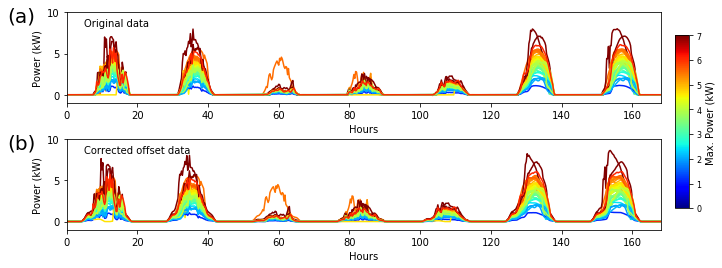

In [30]:
Gen = np.genfromtxt('IntermediateData/correctedPecanGenFeb.csv', delimiter=',')
fig = plt.figure()
fig.set_size_inches(10,4)
ax1 = fig.add_subplot(211)
for i in np.arange(0,160,3):
    cl = scalarMap3.to_rgba(np.max(Gen0[i,0:672]))
    index1 = 0
    index2 = 672
    ax1.plot(np.linspace(0.25,168,672), Gen0[i, index1:index2], color=colors.rgb2hex(cl)) 
ax1.set_xlabel('Hours', fontsize=fs)
ax1.set_ylabel('Power (kW)', fontsize=fs)
ax1.set_xlim([0,168]);
ax1.set_ylim([-1,10])
ax1.text(0.03,0.85,'Original data',transform = ax1.transAxes,fontsize=fs)
ax1.text(-0.1,0.9,'(a)',transform = ax1.transAxes,fontsize=20) 

ax1 = fig.add_subplot(212)
for i in np.arange(0,160,3):
    cl = scalarMap3.to_rgba(np.max(Gen[i,0:672]))
    index1 = 0
    index2 = 672
    ax1.plot(np.linspace(0.25,168,672), Gen[i, index1:index2], color=colors.rgb2hex(cl)) 
ax1.set_xlabel('Hours', fontsize=fs)
ax1.set_ylabel('Power (kW)', fontsize=fs)
ax1.set_xlim([0,168]);
ax1.set_ylim([-1,10])

fig.subplots_adjust(right=0.95, hspace=0.4)
cbar_ax = fig.add_axes([0.97, 0.2, 0.02, 0.6])
cbar = fig.colorbar(scalarMap3, cax=cbar_ax, orientation='vertical', ticks=np.arange(0,7.1,1))
cbar_ax.tick_params(axis='both', which='major', labelsize=fs-2)
cbar.set_label('Max. Power (kW)')

ax1.text(0.03,0.85,'Corrected offset data',transform = ax1.transAxes,fontsize=fs)
ax1.text(-0.1,0.9,'(b)',transform = ax1.transAxes,fontsize=20)


In [31]:
# now select generation preserving the distribution of installed power to use
recordGenNodes = np.zeros((len(WSpace)))
# give each consumer generation
generation=np.zeros(np.shape(cambridgeDemand))

Gen = np.genfromtxt('IntermediateData/correctedPecanGenFeb.csv', delimiter=',')

for i in range(len(cambridgeDemand)):
    accept = 0
    while accept == 0:
        pick = random.randrange(len(Gen))
        # for each user pick a random solar output
        PU = np.sum(Gen[pick,:])/np.sum(cambridgeDemand[i,:])
        # calculate the acceptance probability
        # constrain so PU (PowerUse) is less than 2.5 - the max value we observe in Pecan
        if PU <= 2.5:
            pAccept = func(UGBins[np.digitize(PU, UGBins)], popt[0], popt[1], popt[2])
        else:
            pAccept = 0
        #print pAccept
        if random.uniform(0, 1) < pAccept:
            accept=1
    recordGenNodes[i] = pick
    generation[i,:] = Gen[pick,:]

In [32]:
# save the Cambridge simulated av generation
np.savetxt('IntermediateData/camGenAv.csv', generation, delimiter=',', fmt='%.5f')
Gen = np.genfromtxt('IntermediateData/correctedPecanGenMay.csv', delimiter=',')
for i in range(len(cambridgeDemand)):
    generation[i,:] = Gen[int(recordGenNodes[i]),:]
# save the simulated Jun generation
np.savetxt('IntermediateData/camGenJun.csv', generation, delimiter=',', fmt='%.5f')
Gen = np.genfromtxt('IntermediateData/correctedPecanGenDec.csv', delimiter=',')
for i in range(len(cambridgeDemand)):
    generation[i,:] = Gen[int(recordGenNodes[i]),:]
# save the simulated Jan generation
np.savetxt('IntermediateData/camGenJan.csv', generation, delimiter=',', fmt='%.5f')

0.11697190461090658 2.499083780889256


Text(0,0.5,'P(Cap-Use)')

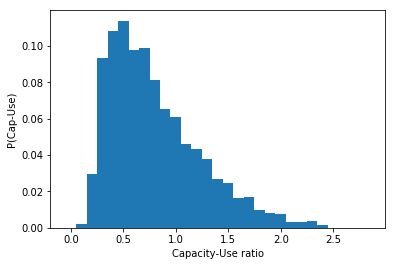

In [33]:
generation = np.genfromtxt('IntermediateData/camGenAv.csv', delimiter=',')

# now plot the distribution of PowerUse
camRats = np.zeros((len(WSpace)))
for i, pLoad in enumerate(cambridgeDemand):
    camRats[i] = np.sum(generation[i,:])/np.sum(pLoad)

print np.min(camRats), np.max(camRats)

UGBins = np.arange(0,3,0.1)
UGHist, UG_edges = np.histogram(camRats, UGBins, density=False)
UGWidths = UG_edges[1:]-UG_edges[:-1]
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.bar(UGBins[:-1], UGHist/float(sum(UGHist)), width=UGWidths)
ax1.set_xlabel('Capacity-Use ratio',fontsize=fs)
ax1.set_ylabel('P(Cap-Use)',fontsize=fs)



In [37]:
# fig1 = plt.figure()
# fig1.set_size_inches(12,4)

# UGHist, UG_edges = np.histogram(pecRats, UGBins, density=False)
# UGWidths = UG_edges[1:]-UG_edges[:-1]
# ax1 = fig1.add_subplot(131)
# ax1.bar(UGBins[:-1], UGHist/float(sum(UGHist)), width=UGWidths, color='red', alpha=0.5)
# ax1.set_xlabel('Generation to consumption ratio',fontsize=fs)
# ax1.set_ylabel('Relative Frequency',fontsize=fs)

# # now inspect the curve fit
# ydata = func(np.linspace(0,3,100), popt[0], popt[1], popt[2])
# l1, = ax1.plot(np.linspace(0,3,100), ydata, linewidth=1.5, color='k')
# r2 = plt.Rectangle((0, 0), 1, 1, fc="red", alpha=0.5)
# ax1.legend([l1, r2], ['Estimated distribution', 'Austin'], loc=1, frameon=False)
# ax1.tick_params(axis='both', which='major', labelsize=fs-1)
# #ax1.set_title('Austin solar capacity to use ratios and fit', y=1.05, fontsize=fs)
# ax1.set_ylim([0, 0.15])
# ax1.text(-0.26,0.9,'(a)',transform = ax1.transAxes,fontsize=20)


# # plot both distributions on the same axis
# UGHist, UG_edges = np.histogram(pecRats, UGBins, density=False)
# UGWidths = UG_edges[1:]-UG_edges[:-1]
# ax1 = fig1.add_subplot(132)
# ax1.bar(UGBins[:-1], UGHist/float(sum(UGHist)), width=UGWidths, color='red', alpha=0.5)
# ax1.set_xlabel('Generation to consumption ratio',fontsize=fs)
# ax1.set_ylabel('Relative Frequency',fontsize=fs)
# UGHist, UG_edges = np.histogram(camRats, UGBins, density=False)
# ax1.bar(UGBins[:-1], UGHist/float(sum(UGHist)), width=UGWidths, color='blue', alpha=0.5)
# r1 = plt.Rectangle((0, 0), 1, 1, fc='b', alpha=0.5)
# r2 = plt.Rectangle((0, 0), 1, 1, fc='r', alpha=0.5)
# ax1.legend([r1, r2], ['Cambridge', 'Austin'], loc=1, frameon=False)
# ax1.tick_params(axis='both', which='major', labelsize=fs-1)
# #ax1.set_title('Cambridge (simulated) and Austin (actual) solar capacity to use ratios', y=1.05, fontsize=fs)
# ax1.set_ylim([0, 0.15])
# ax1.text(-0.26,0.9,'(b)',transform = ax1.transAxes,fontsize=20)


# # look at the misalignments of the Cambridge users
# mis = np.zeros((len(WSpace)))
# for i, cLoad in enumerate(cambridgeDemand):
#     load = cLoad - generation[i,:]
#     mis[i] = -np.sum(load[load<0])/np.sum(generation[i,:])

# misBins = np.arange(0,1.1,0.1)
# misHist, mH_edges = np.histogram(mis, misBins, density=False)
# fs = 12
# misWidths = mH_edges[1:]-mH_edges[:-1]
# ax1 = fig1.add_subplot(133)

# PecHist = np.genfromtxt('IntermediateData/AustinMisalignment.dat', delimiter=',')
# ax1.bar(misBins[:-1], PecHist, width=misWidths, color='r', alpha=0.5)
# r1 = plt.Rectangle((0, 0), 1, 1, fc='blue', alpha=0.5)
# r2 = plt.Rectangle((0, 0), 1, 1, fc='red', alpha=0.5)
# ax1.legend([r1,r2], ['Cambridge', 'Austin'], loc=2, frameon=False)
# ax1.tick_params(axis='both', which='major', labelsize=fs-1)
# ax1.bar(misBins[:-1], misHist/float(sum(misHist)), width=misWidths, color='b', alpha=0.5)
# ax1.set_xlabel('Cambridge misalignment',fontsize=fs)
# ax1.set_ylabel('Relative Frequency',fontsize=fs)
# ax1.set_ylim([0, max(misHist/float(sum(misHist)))+0.01])
# ax1.set_ylim([0, 0.3])
# ax1.text(-0.24,0.9,'(c)',transform = ax1.transAxes,fontsize=20)
# fig1.tight_layout()

# #fig1.savefig('Images/GentoUseRatio.png', dpi=300,bbox_inches = 'tight',format='png')


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


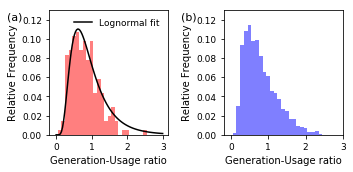

In [35]:
fig1 = plt.figure()
fig1.set_size_inches(5,2.5)
fs=10
UGHist, UG_edges = np.histogram(pecRats, UGBins, density=False)
UGWidths = UG_edges[1:]-UG_edges[:-1]
ax1 = fig1.add_subplot(121)
ax1.bar(UGBins[:-1], UGHist/float(sum(UGHist)), width=UGWidths, color='red', alpha=0.5)
ax1.set_xlabel('Generation-Usage ratio',fontsize=fs)
ax1.set_ylabel('Relative Frequency',fontsize=fs)

# now inspect the curve fit
ydata = func(np.linspace(0,3,100), popt[0], popt[1], popt[2])
l1, = ax1.plot(np.linspace(0,3,100), ydata, linewidth=1.5, color='k')
r2 = plt.Rectangle((0, 0), 1, 1, fc="red", alpha=0.5)
ax1.legend([l1], ['Lognormal fit'], loc=1, frameon=False, fontsize=fs-1)
ax1.tick_params(axis='both', which='major', labelsize=fs-1)
#ax1.set_title('Austin solar capacity to use ratios and fit', y=1.05, fontsize=fs)
ax1.set_ylim([0, 0.13])
ax1.text(-0.35,0.92,'(a)',transform = ax1.transAxes,fontsize=11)
ax1.set_yticks(np.arange(0,0.121,0.02))


# plot both distributions on the same axis
UGHist, UG_edges = np.histogram(pecRats, UGBins, density=False)
UGWidths = UG_edges[1:]-UG_edges[:-1]
ax1 = fig1.add_subplot(122)
ax1.set_xlabel('Generation-Usage ratio',fontsize=fs)
ax1.set_ylabel('Relative Frequency',fontsize=fs)
UGHist, UG_edges = np.histogram(camRats, UGBins, density=False)
ax1.bar(UGBins[:-1], UGHist/float(sum(UGHist)), width=UGWidths, color='blue', alpha=0.5)
r1 = plt.Rectangle((0, 0), 1, 1, fc='b', alpha=0.5)
r2 = plt.Rectangle((0, 0), 1, 1, fc='r', alpha=0.5)
ax1.tick_params(axis='both', which='major', labelsize=fs-1)
#ax1.set_title('Cambridge (simulated) and Austin (actual) solar capacity to use ratios', y=1.05, fontsize=fs)
ax1.set_ylim([0, 0.13])
ax1.set_yticks(np.arange(0,0.121,0.02))
ax1.text(-0.36,0.92,'(b)',transform = ax1.transAxes,fontsize=11)

fig1.tight_layout()
#fig1.savefig('Images/CESnew4.png', dpi=300,bbox_inches = 'tight',format='png')


(0, 0.2485220813292523)

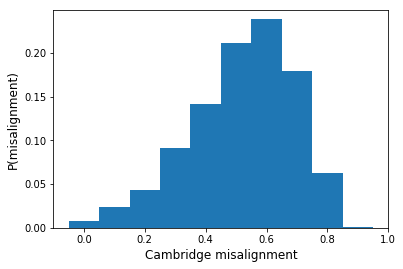

In [36]:
# look at the misalignments of the Cambridge users
mis = np.zeros((len(WSpace)))
for i, cLoad in enumerate(cambridgeDemand):
    load = cLoad - generation[i,:]
    mis[i] = -np.sum(load[load<0])/np.sum(generation[i,:])

misBins = np.arange(0,1.1,0.1)
misHist, mH_edges = np.histogram(mis, misBins, density=False)
fs = 12
misWidths = mH_edges[1:]-mH_edges[:-1]
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.bar(misBins[:-1], misHist/float(sum(misHist)), width=misWidths)
ax1.set_xlabel('Cambridge misalignment',fontsize=fs)
ax1.set_ylabel('P(misalignment)',fontsize=fs)
ax1.set_ylim([0, max(misHist/float(sum(misHist)))+0.01])